In [1]:
import pickle
import numpy as np
import scvelo as scv
import scanpy
import scipy
import torch

from veloproj import *
from matplotlib import pyplot as plt


In [2]:
parser = get_parser()
args = parser.parse_args(args=['--lr',  '1e-6',
                               '--n-epochs', '20000', 
                               '--g-rep-dim', '100',
                               '--k-dim', '100',
                               '--data-dir', '/data/users/cqiao/notebooks/projects/PaperRev/VeloRep2/endocrinogenesis_day15.5.h5ad',
                               '--model-name', 'pancreas_model.cpt',
                               '--exp-name', 'CohAE_pancreas',
                               '--device', 'cuda:2',
                               '--gumbsoft_tau', '1',
                               '--nb_g_src', 'SU',
                               '--n_raw_gene', '2000',
                               '--n_conn_nb', '30',
                               '--n_nb_newadata', '30',
                               '--aux_weight', '1',
                            #    '--sl1_beta', '2',
                            #    '--v_rg_wt', '0.1', # <= 0 means not using velocity constraint loss
                               '--fit_offset_train', None,
                               '--fit_offset_pred', 'True',
                               '--use_offset_pred', None, # we remove offset after low-dimensional linear regression with offset,
                                                          # to further denoise output, since during training we did not use offset 
                                                          # in order to make the low dimensions centered (i.e., offset = 0) for linear regression. So, Ideally, when fitting 
                                                          # linear regression with offset after training veloAE, the offset should be close to zero.
                                                          # But fitting with an offset may alow gamma to be less prone to noises.
                               '--use_gcn', None # 'True' #: GCN, None: GAT
                              ])

In [3]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")

In [4]:
cluster_edges = [
    ("Ngn3 low EP", "Ngn3 high EP"), 
    ("Ngn3 high EP", "Fev+"), 
    ("Fev+", "Alpha"), 
    ("Fev+", "Beta"), 
    ("Fev+", "Delta"), 
    ("Fev+", "Epsilon")]
k_cluster = "clusters"
EXP_NAME = args.exp_name
exp_metrics = {}

In [5]:
def main_AE(args, adata):
    spliced = adata.layers['Ms']
    unspliced = adata.layers['Mu']
    tensor_s = torch.FloatTensor(spliced).to(device)
    tensor_u = torch.FloatTensor(unspliced).to(device)
    tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
    tensor_v = torch.FloatTensor(adata.layers['stc_velocity']).to(device)

    model = init_model(adata, args, device)

    inputs = [tensor_s, tensor_u]
    xyids = [0, 1]
    if args.use_x:
        inputs.append(tensor_x)

    model = fit_model(args, adata, model, inputs, tensor_v, xyids, device)
    return tensor_s, tensor_u, tensor_x  

In [6]:
adata = scanpy.read_h5ad(args.data_dir)
scv.pp.neighbors(adata, n_neighbors=30, n_pcs=30)
scv.utils.show_proportions(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=args.n_raw_gene)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
print(adata)

computing neighbors
    finished (0:00:06) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
Abundance of ['spliced', 'unspliced']: [0.81 0.19]
Filtered out 22769 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
AnnData object with n_obs × n_vars = 2531 × 2000
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'clusters_colors', 'clusters_fine_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors',

computing velocities
    finished (0:00:01) --> added 
    'stc_velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/40 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:07) --> added 
    'stc_velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'stc_velocity_length' (adata.obs)
--> added 'stc_velocity_confidence' (adata.obs)
--> added 'stc_velocity_confidence_transition' (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'stc_velocity_umap', embedded velocity vectors (adata.obsm)


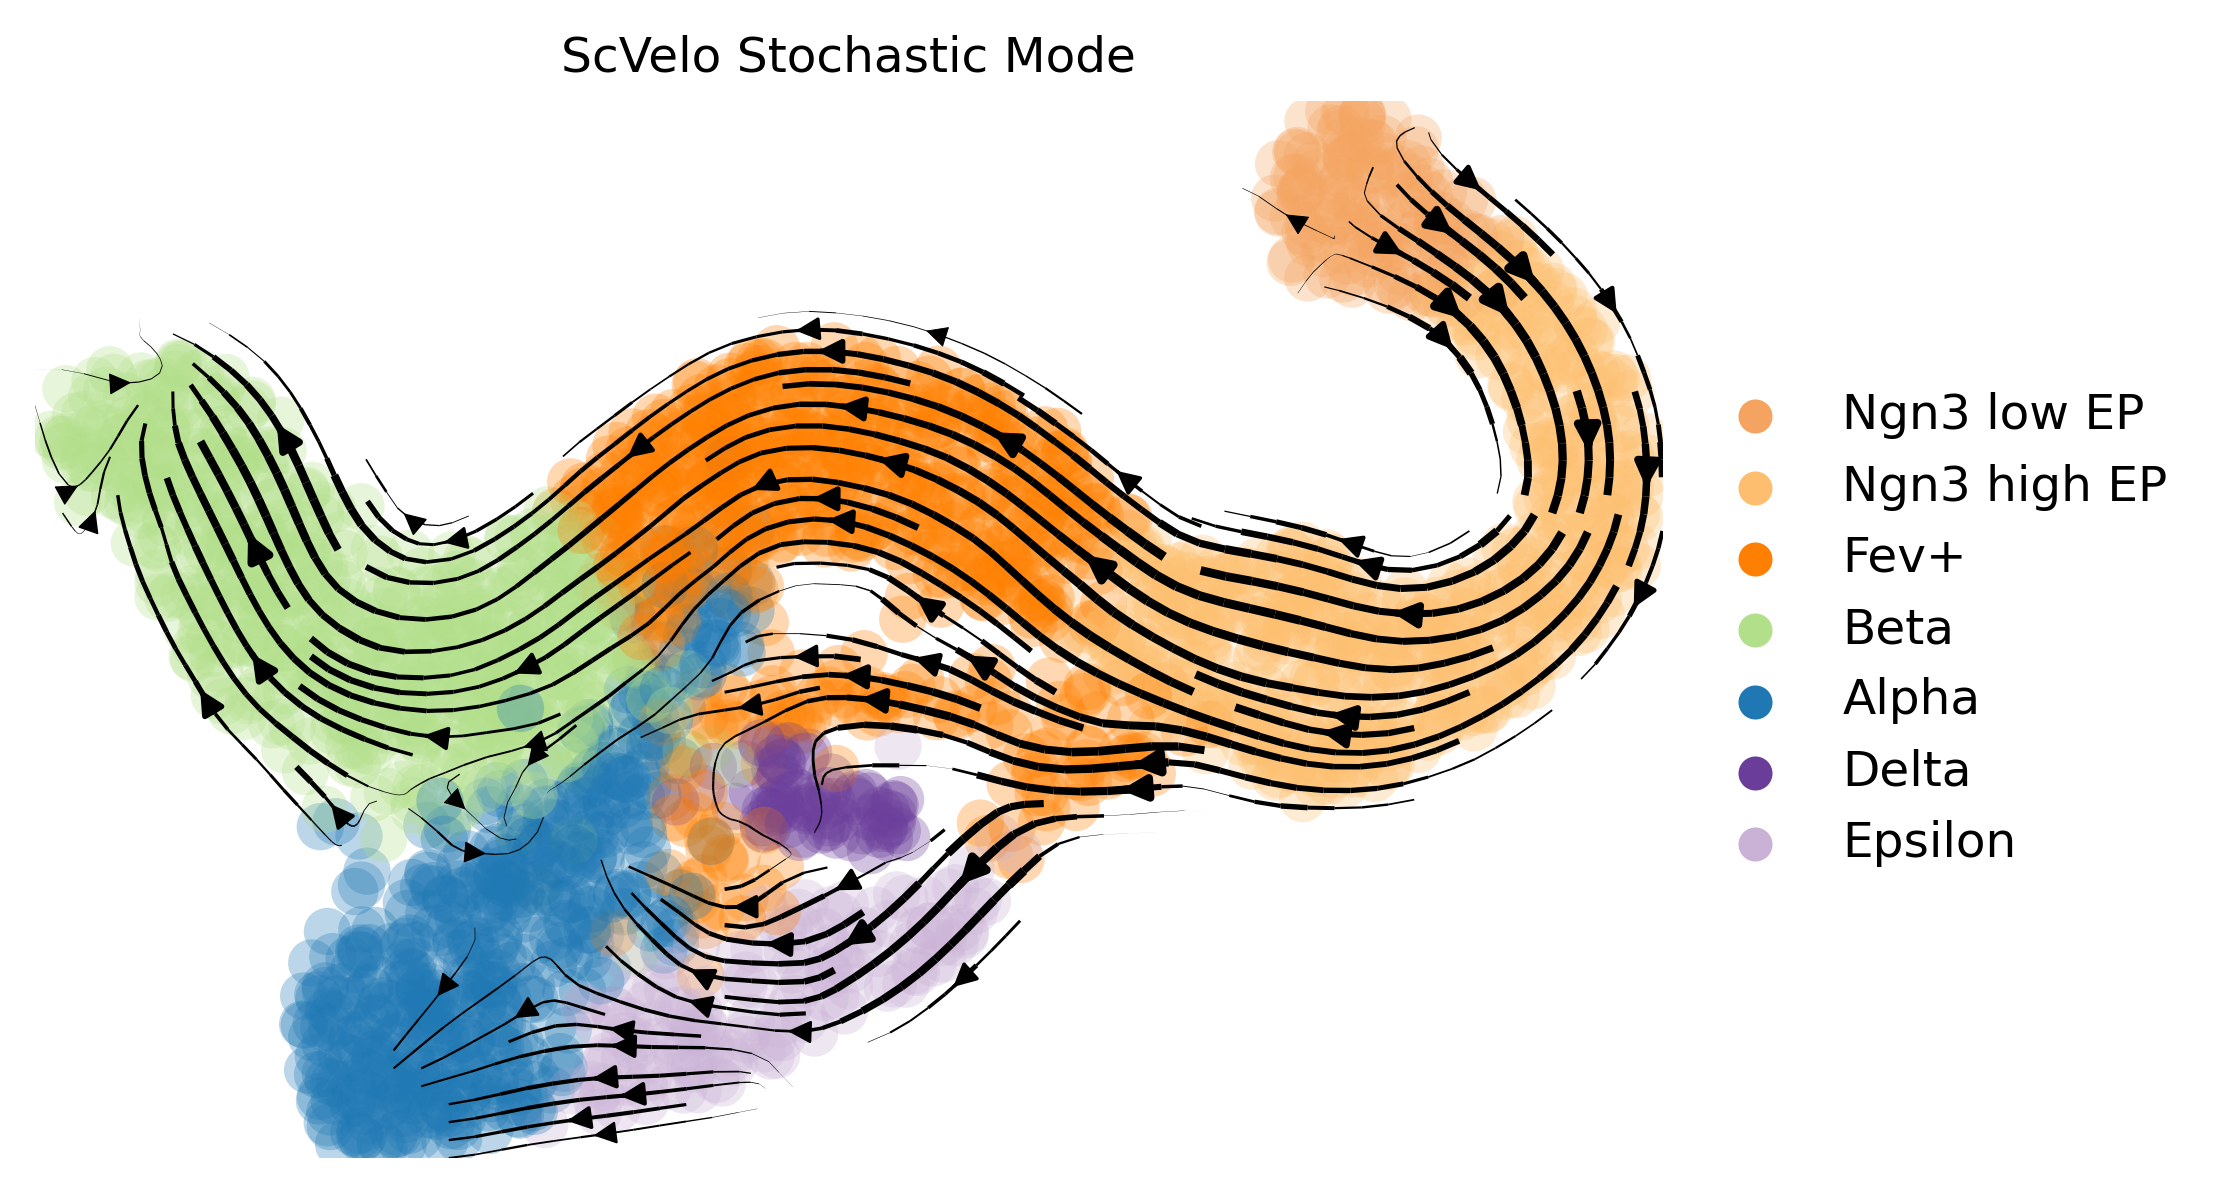

# Cross-Boundary Transition Score (A->B)
{('Ngn3 low EP', 'Ngn3 high EP'): 0.15623182, ('Ngn3 high EP', 'Fev+'): 0.23484711, ('Fev+', 'Alpha'): 0.19807771, ('Fev+', 'Beta'): 0.24194431, ('Fev+', 'Delta'): 0.19956161, ('Fev+', 'Epsilon'): 0.102914006}
Total Mean: 0.18892942368984222
# Cross-Boundary Velocity Coherence (A->B)
{('Ngn3 low EP', 'Ngn3 high EP'): 0.97805756, ('Ngn3 high EP', 'Fev+'): 0.8823927, ('Fev+', 'Alpha'): 0.71744776, ('Fev+', 'Beta'): 0.6556835, ('Fev+', 'Delta'): 0.79728156, ('Fev+', 'Epsilon'): 0.8656598}
Total Mean: 0.8160871863365173
# Cross-Boundary Direction Correctness (A->B)
{('Ngn3 low EP', 'Ngn3 high EP'): 0.8427982370965097, ('Ngn3 high EP', 'Fev+'): 0.6803993564690878, ('Fev+', 'Alpha'): 0.4605180948794976, ('Fev+', 'Beta'): 0.7558329792877547, ('Fev+', 'Delta'): 0.11593190495335362, ('Fev+', 'Epsilon'): 0.01687291708060246}
Total Mean: 0.47872558162780093
# In-cluster Coherence
{'Alpha': 0.72817194, 'Beta': 0.74304336, 'Delta': 0.776115, 'Epsilon': 0.855

In [7]:
scv.tl.velocity(adata, vkey='stc_velocity', mode="stochastic")
scv.tl.velocity_graph(adata, vkey='stc_velocity')
scv.tl.velocity_confidence(adata, vkey='stc_velocity')
scv.pl.velocity_embedding_stream(adata,  legend_loc="right margin", vkey="stc_velocity", basis='X_umap', color=k_cluster,
                                 dpi=350, 
                                title='ScVelo Stochastic Mode')
exp_metrics["stc_mode"] = evaluate(adata, cluster_edges, k_cluster, "stc_velocity")

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Train Epoch: 100/20000 	Loss: 33.660187
Train Epoch: 200/20000 	Loss: 33.444672
Train Epoch: 300/20000 	Loss: 33.219856
Train Epoch: 400/20000 	Loss: 32.869385
Train Epoch: 500/20000 	Loss: 32.446037
Train Epoch: 600/20000 	Loss: 32.091564
Train Epoch: 700/20000 	Loss: 31.747709
Train Epoch: 800/20000 	Loss: 31.388098
Train Epoch: 900/20000 	Loss: 31.073757
Train Epoch: 1000/20000 	Loss: 30.745222
Train Epoch: 1100/20000 	Loss: 30.441244
Train Epoch: 1200/20000 	Loss: 30.107496
Train Epoch: 1300/20000 	Loss: 29.743069
Train Epoch: 1400/20000 	Loss: 29.377920
Train Epoch: 1500/20000 	Loss: 29.015541
Train Epoch: 1600/20000 	Loss: 28.649736
Train Epoch: 1700/20000 	Loss: 28.320831
Train Epoch: 1800/20000 	Loss: 28.00

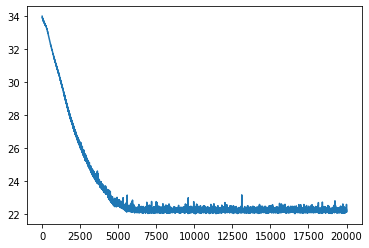

In [8]:
tensor_s, tensor_u, tensor_x = main_AE(args, adata)

computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph (using 1/40 cores)
    finished (0:00:02) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_pancreas_pojection.png


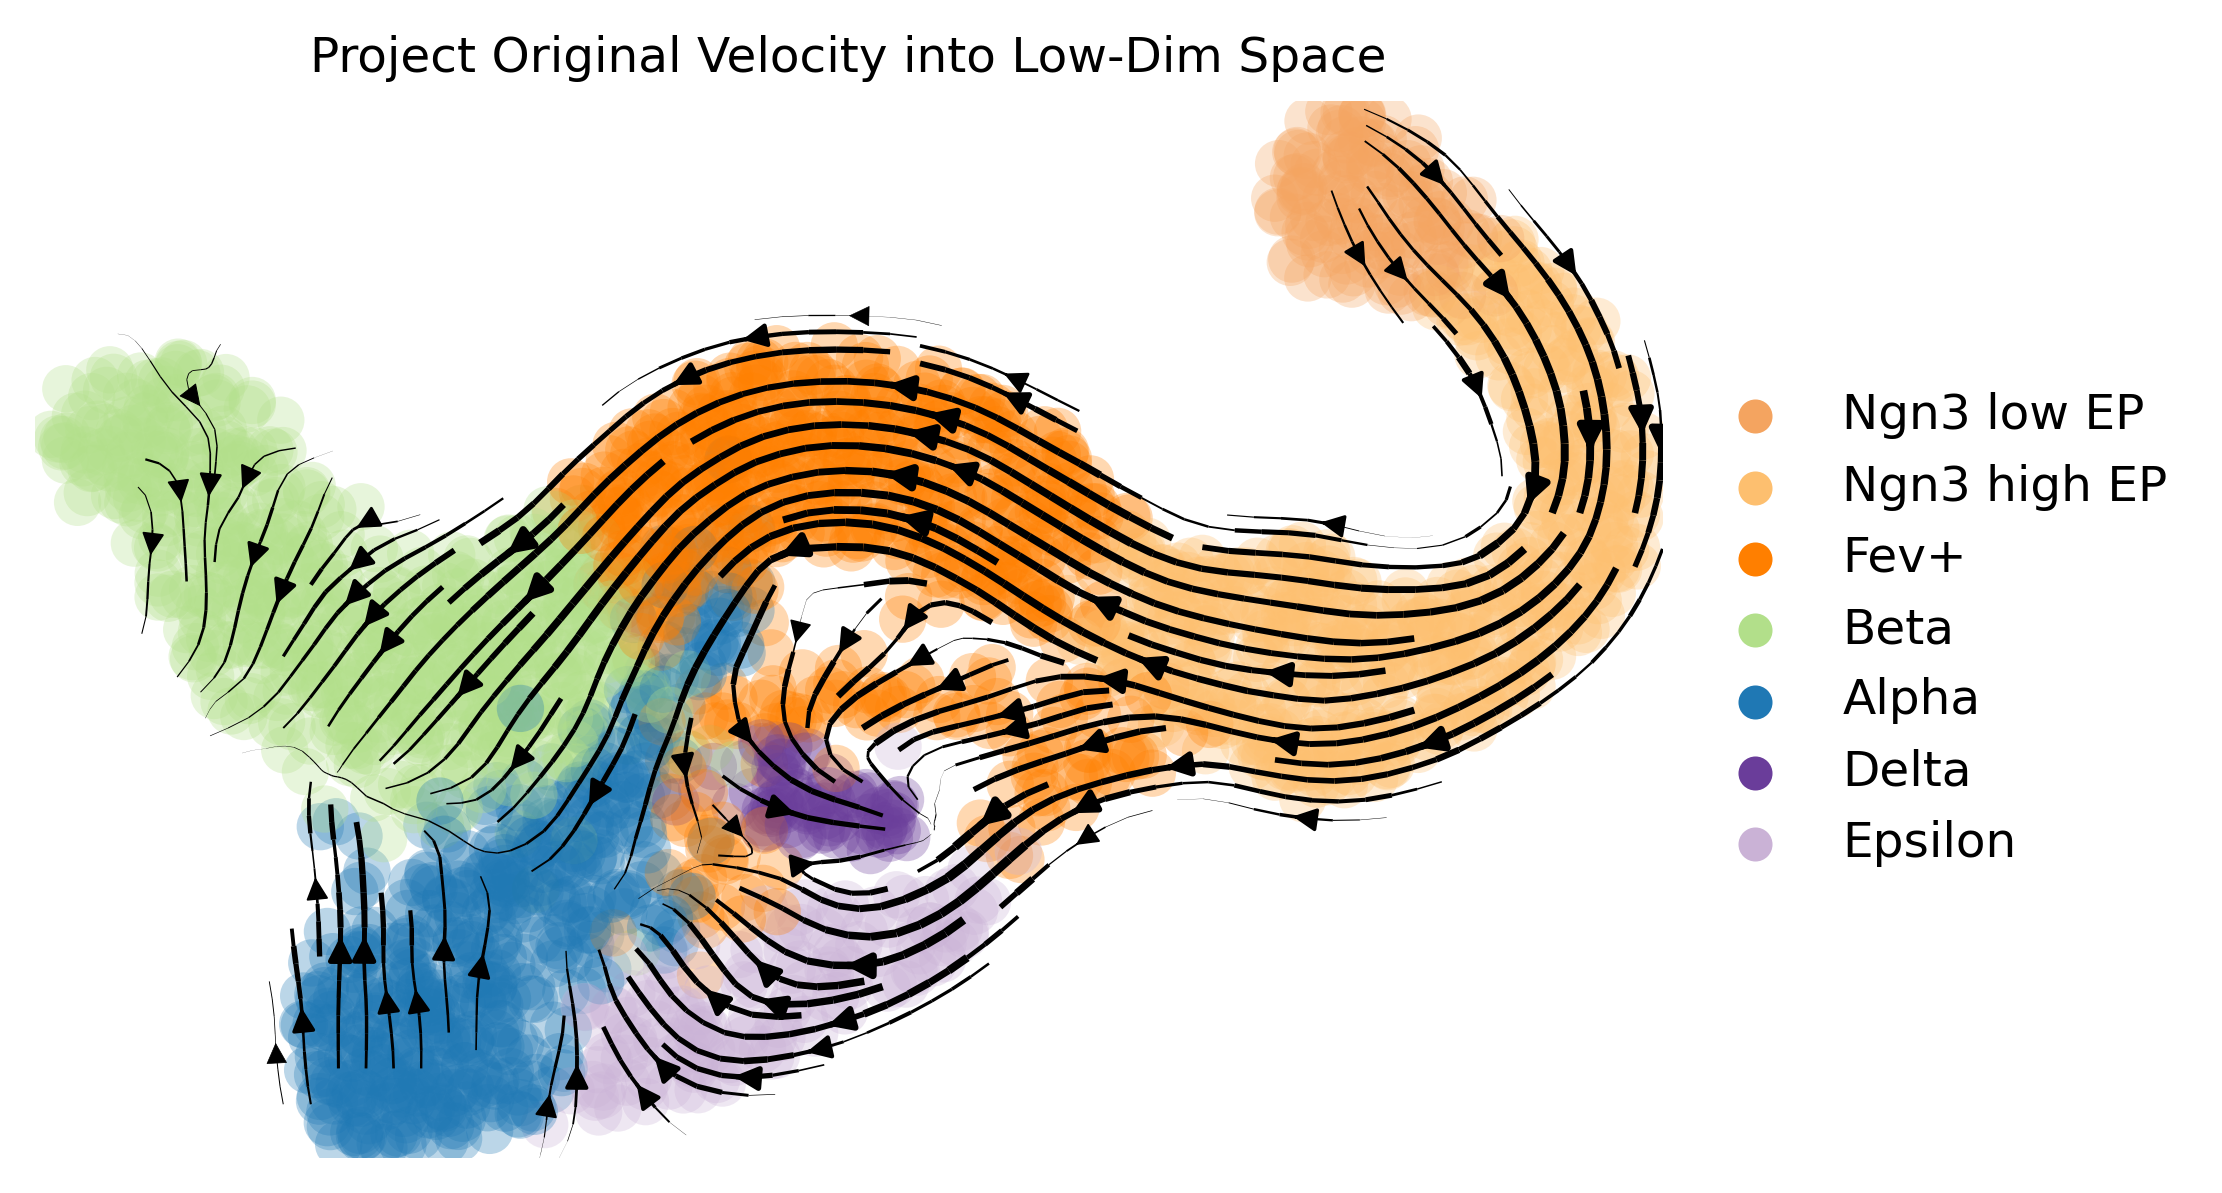

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('Ngn3 low EP', 'Ngn3 high EP'): 0.5788157, ('Ngn3 high EP', 'Fev+'): 0.77572656, ('Fev+', 'Alpha'): 0.70469964, ('Fev+', 'Beta'): 0.73974156, ('Fev+', 'Delta'): 0.9101197, ('Fev+', 'Epsilon'): 0.37367034}
Total Mean: 0.6804621815681458
# Cross-Boundary Velocity Coherence (A->B)
{('Ngn3 low EP', 'Ngn3 high EP'): 0.9999507, ('Ngn3 high EP', 'Fev+'): 0.99997747, ('Fev+', 'Alpha'): 0.9997371, ('Fev+', 'Beta'): 0.99969006, ('Fev+', 'Delta'): 0.99964833, ('Fev+', 'Epsilon'): 0.9996089}
Total Mean: 0.9997687339782715
# Cross-Boundary Direction Correctness (A->B)
{('Ngn3 low EP', 'Ngn3 high EP'): 0.7643228890298288, ('Ngn3 high EP', 'Fev+'): 0.6267967025801323, ('Fev+', 'Alpha'): 0.3497772765270711, ('Fev+', 'Beta'): 0.5499117980295153, ('Fev+', 'Delta'): 0.5413076456737793, ('Fev+', 'Epsilon'): 0.03997

In [9]:
def exp(adata, exp_metrics):
    model = init_model(adata, args, device)
    model.load_state_dict(torch.load(args.model_name))
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        v = estimate_ld_velocity(s, u, device=device, perc=[5, 95], 
                                 norm=args.use_norm, fit_offset=args.fit_offset_pred, 
                                 use_offset=args.use_offset_pred).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
    
    adata = new_adata(adata, x, s, u, v, g_basis='X', n_nb_newadata=args.n_nb_newadata)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, legend_loc='right_margin', vkey="new_velocity", basis='X_umap', color=k_cluster,
                                    title="Project Original Velocity into Low-Dim Space",
                                    dpi=350,
                                    save='pancreas_pojection.png')  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Cohort AutoEncoder'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
exp(adata, exp_metrics)

In [10]:
with open("{}.pkl".format(EXP_NAME), 'wb') as out_file:
    pickle.dump(exp_metrics, out_file)